# CS396 Data Science: Project

### Project Overview
This project aims to understand any underlying biases or trends on Yelp by answering the following questions:
1. Is there a correlation between a user's activity/popularity and their review score distribution?
2. Do Yelp users have similar behaviors to their friends on the platform?
3. Is there a correlation between review score and whether it was made during the business' operating hours?
4. Is there a correlation between number of reviews on a business and its score distribution?

### Data Used
All of these questions were answered using various data sources included in the Yelp Open Dataset. The specific files used for each question are listed below:
1. user.json, review.json
2. user.json, review.json
3. business.json, review.json
4. business.json, review.json

## Environment Setup and Utility Functions

In [32]:
DATA_PATH = '../../yelp_dataset/'

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def load_data(path):
    """Load Yelp data file
    Currently only JSON and pickle format supported
    
    function(string) => pd.DataFrame"""
    f_type = path.split('.')[-1]
    
    if f_type == 'json': 
        return pd.DataFrame.from_records([json.loads(l) for l in open(DATA_PATH+path, encoding='utf-8')])
    elif f_type in ['pickle', 'pkl']:
        return pd.read_pickle(DATA_PATH+path)
    else:
        raise ValueError('Unsupported file type provided "{0}"'.format(f_type))
        

def save_data(df, path):
    """Save pd.DataFrame to specified file
    Currently only JSON and pickle format supported
    
    function(pd.DataFrame, string) => None"""
    f_type = path.split('.')[-1]
    
    if f_type == 'json':
        with open(DATA_PATH+path, 'w', encoding='utf-8') as out:
            for i, r in df.iterrows():
                print(r.to_json(), file=out)
        return
    elif f_type in ['pickle', 'pkl']:
        df.to_pickle(DATA_PATH+path)
        return
    else:
        raise ValueError('Unsupported file type provied "{0}"'.format(f_type))
 

def drop_null(df, subset=None):
    """Remove null values (or subset) and return statistics
    
    function(pd.DataFrame, List[String]) => pd.DataFrame, Number, Number
    """
    # Remove null data
    clean = df.dropna() if not subset else df.dropna(subset=subset)
    
    # Compute statistics
    num_null = len(df) - len(clean)
    percent_null = (num_null / len(df)) * 100
    
    return clean, num_null, percent_null       

## Data Cleaning

### Convert JSON to Pickle
All of the data files that will be used are converted to pickle format for significantly faster load times and performance. This process takes a long time to complete (>20 minutes on my system) and requires significant computational resources (>8 GB RAM usage), but saves time in the long run with significantly decreased loading times for later access. This also slightly increases data density, saving about 1 GB in total across the files transcoded.

In [50]:
'''
# Commented out to prevent accidental execution
files = ['yelp_academic_dataset_user', 'yelp_academic_dataset_review', 'yelp_academic_dataset_business']
for f in files:
    df = load_data(f+'.json')
    save_data(df, f+'.pickle')
'''

### General Data Cleaning
The cleaning for each dataset is handled by its own clean_{dataset} function. This allows for more precising cleaning to be added in the future in the event that it is needed. For the analysis that will be performed here, there is very little data cleaning that needs to be performed; aside from dropping null values, the user and business datasets need to be checked for duplicate user_id and business_id respectively. Upon analyzing the data used here, there were no such duplicates found, so the currently implementation of clean_{dataset} only serves as an alert of duplicate entries. There is no need to resolve any textual errors, such as an incorrect city name, as those will not be analyzed in this project and do not affect the other results.

#### User Data Cleaning

In [8]:
def clean_user(df):
    """Apply cleaning to user dataset or a subset of it
    
    function(pd.DataFrame) => pd.DataFrame
    """
    print('=== User Data Cleaning Results ===')
    
    # Clean out entries with null values
    clean, num_null, percent_null = drop_null(df)
    print('  Null entries dropped:  {0} ({1}%)'.format(num_null, round(percent_null, 2)))
    
    # Ensure no duplicate user_ids
    num_duplicates = len(clean) - len(clean.user_id.unique())
    print('  Duplicate user_id:     {0}'.format(num_duplicates))
    
    return clean

In [4]:
df = load_data('yelp_academic_dataset_user.pickle')
df = clean_user(df)

=== User Data Cleaning Results ===
  Null entries dropped: 0 (0.0%)
  Duplicate user_id:    0


#### Business Data Cleaning

In [9]:
def clean_business(df):
    """Apply cleaning to business dataset or a subset of it
    
    function(pd.DataFrame) => pd.DataFrame
    """
    print("=== Business Data Cleaning Results ===")
    
    # Clean out null values
    clean, num_null, percent_null = drop_null(df, subset=['stars', 'review_count', 'is_open', 'hours'])
    print('  Null entries dropped:   {0} ({1}%)'.format(num_null, round(percent_null, 2)))
    
    # Ensure no duplicate business_id's
    num_duplicates = len(clean) - len(clean.business_id.unique())
    print('  Duplicate business_id:  {0}'.format(num_duplicates))
    
    return clean

In [22]:
df = load_data('yelp_academic_dataset_business.pickle')
df = clean_business(df)

=== Business Data Cleaning Results ===
  Null entries dropped:   27341 (17.03%)
  Duplicate business_id:  0


#### Review Data Cleaning

In [10]:
def clean_review(df):
    """Apply cleaning to review dataset or a subset of it
    
    function(pd.DataFrame) => pd.DataFrame
    """
    print("=== Review Data Cleaning Results ===")
    
    # Clean out null values
    clean, num_null, percent_null = drop_null(df)
    print('  Null entries dropped:  {0} ({1}%)'.format(num_null, round(percent_null, 2)))
    
    return clean

In [12]:
df = load_data('yelp_academic_dataset_review.pickle')
df = clean_review(df)

=== Review Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)


## Exploratory Data Analysis

### Business Data

In [13]:
df = load_data('yelp_academic_dataset_business.pickle')

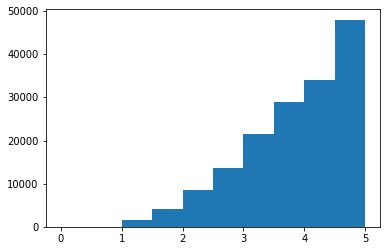

In [42]:
plt.hist(df.stars, bins=[0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.show()

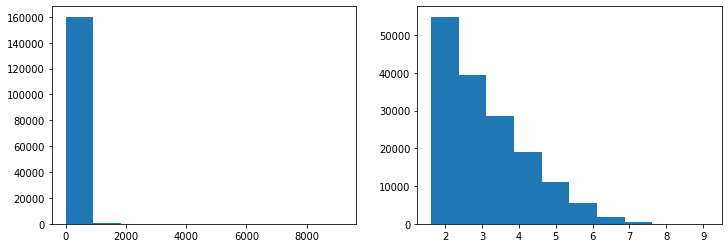

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(df.review_count)
ax[1].hist(np.log(df.review_count))
plt.show()

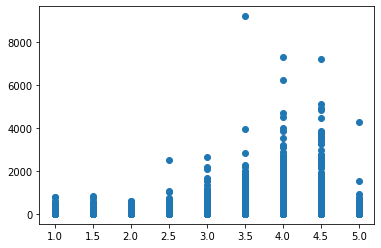

In [38]:
plt.scatter(df.stars, df.review_count)
plt.show()

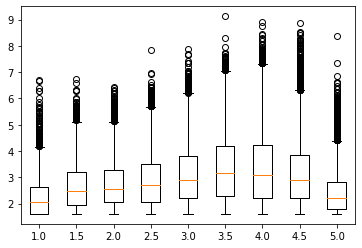

In [41]:
star_splits = [i*0.5 + 1 for i in range(0,9)]
splits = [np.log(df[df.stars==s].review_count) for s in star_splits]
plt.boxplot(splits)
plt.xticks(list(range(1,10)), star_splits)
plt.show()